# Lab | API wrappers - Create your collection of songs & audio features (GNOD - part 3)

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from pandas import json_normalize
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

In [2]:
secrets_file = open("secrets.txt","r") 

In [3]:
string = secrets_file.read()

In [4]:
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        #print(line.split(':'))
        secrets_dict[line.split(':')[0]]=line.split(':')[1].strip()

In [5]:
#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['clientid'],
                                                           client_secret=secrets_dict['clientsecret']))

In [6]:
pd.set_option("display.max_columns", 0)
# we will use our 'first paid music' playlist as an example:
playlist = sp.user_playlist_tracks("spotify", "5S8SJdl1BDc0ugpkEvFsIL")

#playlist

In [7]:
playlist["total"] #we have total of 10000 songs

10000

In [8]:
# we could use the url to the next page which is provided...
playlist['next']

'https://api.spotify.com/v1/playlists/5S8SJdl1BDc0ugpkEvFsIL/tracks?offset=100&limit=100&additional_types=track'

In [9]:
from random import randint
import time

#fetching all tracks from a Spotify playlist, handling pagination 
def get_playlist_tracks(playlist_id):
    tracks = []
    results = sp.user_playlist_tracks("spotify", playlist_id)
   
    # Initial retrieval of tracks
    tracks = results['items']

    # Keep fetching more tracks until there are no more pages
    while results['next'] is not None: 
        results = sp.next(results) #it repeatedly fetches the next page of tracks using the sp.next() function until there are no more pages left 
        tracks = tracks + results['items']
        time.sleep(randint(1, 3) / 1000)  # Add a small delay to avoid rate limiting
    
    return tracks


In [10]:
#retrieves all the tracks from the Spotify playlist identified by the given ID and returns them as a list.
all_tracks = get_playlist_tracks("5S8SJdl1BDc0ugpkEvFsIL")
len(all_tracks)

10000

In [11]:
tracks2 = json_normalize(all_tracks)

In [12]:
tracks2

,added_at,is_local,primary_color,added_by.external_urls.spotify,added_by.href,added_by.id,added_by.type,added_by.uri,track.preview_url,track.available_markets,track.explicit,track.type,track.episode,track.track,track.album.available_markets,track.album.type,track.album.album_type,track.album.href,track.album.id,track.album.images,track.album.name,track.album.release_date,track.album.release_date_precision,track.album.uri,track.album.artists,track.album.external_urls.spotify,track.album.total_tracks,track.artists,track.disc_number,track.track_number,track.duration_ms,track.external_ids.isrc,track.external_urls.spotify,track.href,track.id,track.name,track.popularity,track.uri,track.is_local,video_thumbnail.url
0,2017-11-20T02:52:18Z,False,None,https://open.spotify.com/user/twgeb7mzdcv4u8h1...,https://api.spotify.com/v1/users/twgeb7mzdcv4u...,twgeb7mzdcv4u8h191dxrvlpc,user,spotify:user:twgeb7mzdcv4u8h191dxrvlpc,None,[],False,track,False,True,[],album,single,https://api.spotify.com/v1/albums/0HG8fMDhvN2t...,0HG8fMDhvN2tH5uPHFsyZP,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",...Ready For It?,2017-09-03,day,spotify:album:0HG8fMDhvN2tH5uPHFsyZP,[{'external_urls': {'spotify': 'https://open.s...,https://open.spotify.com/album/0HG8fMDhvN2tH5u...,1.0,[{'external_urls': {'spotify': 'https://open.s...,1,1,208198,USCJY1750003,https://open.spotify.com/track/7zgqtptZvhf8GEm...,https://api.spotify.com/v1/tracks/7zgqtptZvhf8...,7zgqtptZvhf8GEmdsM2vp2,...Ready For It?,0,spotify:track:7zgqtptZvhf8GEmdsM2vp2,False,None
1,2017-11-20T02:42:15Z,False,None,https://open.spotify.com/user/twgeb7mzdcv4u8h1...,https://api.spotify.com/v1/users/twgeb7mzdcv4u...,twgeb7mzdcv4u8h191dxrvlpc,user,spotify:user:twgeb7mzdcv4u8h191dxrvlpc,None,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",False,track,False,True,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",album,album,https://api.spotify.com/v1/albums/4w5Jvreahp3y...,4w5Jvreahp3yvLqc4vCr9I,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Life Changes,2017-09-08,day,spotify:album:4w5Jvreahp3yvLqc4vCr9I,[{'external_urls': {'spotify': 'https://open.s...,https://open.spotify.com/album/4w5Jvreahp3yvLq...,14.0,[{'external_urls': {'spotify': 'https://open.s...,1,8,190226,USLXJ1707376,https://open.spotify.com/track/4Vxu50qVrQcycjR...,https://api.spotify.com/v1/tracks/4Vxu50qVrQcy...,4Vxu50qVrQcycjRyJQaZLC,Life Changes,60,spotify:track:4Vxu50qVrQcycjRyJQaZLC,False,None
2,2017-11-20T02:36:40Z,False,None,https://open.spotify.com/user/twgeb7mzdcv4u8h1...,https://api.spotify.com/v1/users/twgeb7mzdcv4u...,twgeb7mzdcv4u8h191dxrvlpc,user,spotify:user:twgeb7mzdcv4u8h191dxrvlpc,https://p.scdn.co/mp3-preview/3a76820d510fa5f8...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",False,track,False,True,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",album,album,https://api.spotify.com/v1/albums/4PgleR09JVnm...,4PgleR09JVnm3zY1fW3XBA,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",24K Magic,2016-11-17,day,spotify:album:4PgleR09JVnm3zY1fW3XBA,[{'external_urls': {'spotify': 'https://open.s...,https://open.spotify.com/album/4PgleR09JVnm3zY...,9.0,[{'external_urls': {'spotify': 'https://open.s...,1,1,225983,USAT21602944,https://open.spotify.com/track/6b8Be6ljOzmkOmF...,https://api.spotify.com/v1/tracks/6b8Be6ljOzmk...,6b8Be6ljOzmkOmFslEb23P,24K Magic,81,spotify:track:6b8Be6ljOzmkOmFslEb23P,False,None
3,2017-12-06T01:26:36Z,False,None,https://open.spotify.com/user/twgeb7mzdcv4u8h1...,https://api.spotify.com/v1/users/twgeb7mzdcv4u...,twgeb7mzdcv4u8h191dxrvlpc,user,spotify:user:twgeb7mzdcv4u8h191dxrvlpc,https://p.scdn.co/mp3-preview/9b7635464dc2caea...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",False,track,False,True,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",album,album,https://api.spotify.com/v1/albums/3T4tUhGYeRNV...,3T4tUhGYeRNVUGevb0wThu,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",÷ (Deluxe),2017-03-03,day,spotify:album:3T4tUhGYeRNVUGevb0wThu,[{'external_urls': {'spotify': 'https://op

In [13]:
artists_data = pd.DataFrame(columns=['href', 'id', 'name', 'type', 'uri', 'external_urls.spotify','song_id', 'song_name', 'popularity' ])

for i in tracks2.index:
    # Extract information about the artists for the current track using json_normalize
    artists_for_song = json_normalize(tracks2.iloc[i]['track.artists'])

    # Add additional columns to the artists_for_song DataFrame
    artists_for_song['song_id']    = tracks2.iloc[i]['track.id']         # we want to keep song_id, it is the sae for all artists
    artists_for_song['song_name']  = tracks2.iloc[i]['track.name']       # we want to keep song_name, it is the sae for all artists
    artists_for_song['popularity'] = tracks2.iloc[i]['track.popularity'] # same for popularity   

    # Concatenate the artists_for_song DataFrame with artists_data 
    artists_data = pd.concat([artists_data, artists_for_song], axis=0)

In [14]:
artists_data.head(80)

,href,id,name,type,uri,external_urls.spotify,song_id,song_name,popularity
0,https://api.spotify.com/v1/artists/06HL4z0CvFA...,06HL4z0CvFAxyc27GXpf02,Taylor Swift,artist,spotify:artist:06HL4z0CvFAxyc27GXpf02,https://open.spotify.com/artist/06HL4z0CvFAxyc...,7zgqtptZvhf8GEmdsM2vp2,...Ready For It?,0
0,https://api.spotify.com/v1/artists/6x2LnllRG5u...,6x2LnllRG5uGarZMsD4iO8,Thomas Rhett,artist,spotify:artist:6x2LnllRG5uGarZMsD4iO8,https://open.spotify.com/artist/6x2LnllRG5uGar...,4Vxu50qVrQcycjRyJQaZLC,Life Changes,60
0,https://api.spotify.com/v1/artists/0du5cEVh5yT...,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,artist,spotify:artist:0du5cEVh5yTK9QJze8zA0C,https://open.spotify.com/artist/0du5cEVh5yTK9Q...,6b8Be6ljOzmkOmFslEb23P,24K Magic,81
0,https://api.spotify.com/v1/artists/6eUKZXaKkcv...,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,artist,spotify:artist:6eUKZXaKkcviH0Ku9w2n3V,https://open.spotify.com/artist/6eUKZXaKkcviH0...,0afhq8XCExXpqazXczTSve,Galway Girl,78
0,https://api.spotify.com/v1/artists/6eUKZXaKkcv...,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,artist,spotify:artist:6eUKZXaKkcviH0Ku9w2n3V,https://open.spotify.com/artist/6eUKZXaKkcviH0...,1HNkqx9Ahdgi1Ixy2xkKkL,Photograph,83
...,...,...,...,...,...,...,...,...,...
0,https://api.spotify.com/v1/artists/31TPClRtHm2...,31TPClRtHm23RisEBtV3X7,Justin Timberlake,artist,spotify:artist:31TPClRtHm23RisEBtV3X7,https://open.spotify.com/artist/31TPClRtHm23Ri...,2JZKXgq5zsokN01KWyiY6n,Mirrors,0
0,https://api.spotify.com/v1/artists/6jJ0s89eD6G...,6jJ0s89eD6GaHleKKya26X,Katy Perry,artist,spotify:artist:6jJ0s89eD6GaHleKKya26X,https://open.spotify.com/artist/6jJ0s89eD6GaHl...,4lCv7b86sLynZbXhfScfm2,Firework,70
0,https://api.spotify.com/v1/artists/6eUKZXaKkcv...,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,artist,spotify:artist:6eUKZXaKkcviH0Ku9w2n3V,https://open.spotify.com/artist/6eUKZXaKkcviH0...,0tgVpDi06FyKpA1z0VMD4v,Perfect,87
0,https://api.spotify.com/v1/artists/1uNFoZAHBGt...,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,artist,spotify:artist:1uNFoZAHBGtllmzznpCI3s,https://open.spotify.com/artist/1uNFoZAHBGtllm...,4B0JvthVoAAuygILe3n4Bs,What Do You Mean?,80


In [15]:
final_songs = artists_data[['song_name', 'name', 'song_id', 'popularity']]
final_songs.reset_index()

,index,song_name,name,song_id,popularity
0,0,...Ready For It?,Taylor Swift,7zgqtptZvhf8GEmdsM2vp2,0
1,0,Life Changes,Thomas Rhett,4Vxu50qVrQcycjRyJQaZLC,60
2,0,24K Magic,Bruno Mars,6b8Be6ljOzmkOmFslEb23P,81
3,0,Galway Girl,Ed Sheeran,0afhq8XCExXpqazXczTSve,78
4,0,Photograph,Ed Sheeran,1HNkqx9Ahdgi1Ixy2xkKkL,83
...,...,...,...,...,...
12173,0,Fool's Overture,Supertramp,5pSSEkT0963muzzIjsVkrs,51
12174,0,Heart of the Sunrise - 2003 Remaster,Yes,7gC6Rbllqf1yXNC02e5jz2,44
12175,0,Venus And Mars / Rock Show / Jet - Live / Rema...,Paul McCartney,6Ff77WXC58MkhLE5A1qgY1,0
12176,1,Venus And Mars / Rock Show / Jet - Live / Rema...,Wings,6Ff77WXC58MkhLE5A1qgY1,0


# Get the audio features 

In [ ]:
#Get the audio_features

#Define Chunk Size:
chunk_size = 100

audio_features_list = []

# Iterate over chunks of track IDs
for i in range(0, len(final_songs), chunk_size): #iterates over the range of track IDs in final_songs DataFrame, with a step size equal to chunk_size. 
    
    # Get IDs for the current chunk
    chunk_ids = final_songs['song_id'].iloc[i:i+chunk_size].tolist() #This selects a chunk of rows from index i to i + chunk_size - 1 from the 'song_id' column.
    
    # Filter out None values from chunk_ids
    valid_chunk_ids = [id for id in chunk_ids if id is not None]
    
    # Call Spotify API to fetch audio features for the current chunk of track IDs
    chunk_audio_features = sp.audio_features(valid_chunk_ids)
    
    # Extend audio_features_list with the fetched audio features
    if chunk_audio_features:
        audio_features_list.extend(chunk_audio_features)
    
    # Add a random delay to avoid rate limiting
    time.sleep(randint(1, 3) / 1000)  # Random delay between 1 to 3 milliseconds (adjust as needed)

# Print the total number of audio features retrieved
print("Total number of audio features retrieved:", len(audio_features_list))

In [17]:
audio_features_df = json_normalize(audio_features_list)

In [18]:
audio_features_df.drop_duplicates(inplace=True) # duplicates because some songs have more artists

In [19]:
#merge two dataframes
df_with_audio_features = pd.merge(left=final_songs,
                        right=audio_features_df,
                        how='inner',
                        left_on='song_id',
                        right_on='id')

#Our data with the audio feautures
df_with_audio_features

,song_name,name,song_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,...Ready For It?,Taylor Swift,7zgqtptZvhf8GEmdsM2vp2,0,0.615,0.779,2.0,-6.454,1.0,0.1350,0.06650,0.000000,0.1550,0.453,160.000,audio_features,7zgqtptZvhf8GEmdsM2vp2,spotify:track:7zgqtptZvhf8GEmdsM2vp2,https://api.spotify.com/v1/tracks/7zgqtptZvhf8...,https://api.spotify.com/v1/audio-analysis/7zgq...,208198.0,4.0
1,Life Changes,Thomas Rhett,4Vxu50qVrQcycjRyJQaZLC,60,0.687,0.845,7.0,-4.370,1.0,0.0575,0.10000,0.000000,0.0452,0.809,87.972,audio_features,4Vxu50qVrQcycjRyJQaZLC,spotify:track:4Vxu50qVrQcycjRyJQaZLC,https://api.spotify.com/v1/tracks/4Vxu50qVrQcy...,https://api.spotify.com/v1/audio-analysis/4Vxu...,190227.0,4.0
2,24K Magic,Bruno Mars,6b8Be6ljOzmkOmFslEb23P,81,0.818,0.803,1.0,-4.282,1.0,0.0797,0.03400,0.000000,0.1530,0.632,106.970,audio_features,6b8Be6ljOzmkOmFslEb23P,spotify:track:6b8Be6ljOzmkOmFslEb23P,https://api.spotify.com/v1/tracks/6b8Be6ljOzmk...,https://api.spotify.com/v1/audio-analysis/6b8B...,225983.0,4.0
3,Galway Girl,Ed Sheeran,0afhq8XCExXpqazXczTSve,78,0.624,0.876,9.0,-3.374,1.0,0.1000,0.07350,0.000000,0.3270,0.781,99.943,audio_features,0afhq8XCExXpqazXczTSve,spotify:track:0afhq8XCExXpqazXczTSve,https://api.spotify.com/v1/tracks/0afhq8XCExXp...,https://api.spotify.com/v1/audio-analysis/0afh...,170827.0,4.0
4,Photograph,Ed Sheeran,1HNkqx9Ahdgi1Ixy2xkKkL,83,0.614,0.379,4.0,-10.480,1.0,0.0476,0.60700,0.000464,0.0986,0.201,107.989,audio_features,1HNkqx9Ahdgi1Ixy2xkKkL,spotify:track:1HNkqx9Ahdgi1Ixy2xkKkL,https://api.spotify.com/v1/tracks/1HNkqx9Ahdgi...,https://api.spotify.com/v1/audio-analysis/1HNk...,258987.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12151,Fool's Overture,Supertramp,5pSSEkT0963muzzIjsVkrs,51,0.406,0.306,3.0,-10.482,1.0,0.0372,0.31300,0.007900,0.0727,0.073,135.272,audio_features,5pSSEkT0963muzzIjsVkrs,spotify:track:5pSSEkT0963muzzIjsVkrs,https://api.spotify.com/v1/tracks/5pSSEkT0963m...,https://api.spotify.com/v1/audio-analysis/5pSS...,652560.0,4.0
12152,Heart of the Sunrise - 2003 Remaster,Yes,7gC6Rbllqf1yXNC02e5jz2,44,0.362,0.507,1.0,-11.229,1.0,0.0394,0.01740,0.216000,0.1130,0.456,146.641,audio_features,7gC6Rbllqf1yXNC02e5jz2,spotify:track:7gC6Rbllqf1yXNC02e5jz2,https://api.spotify.com/v1/tracks/7gC6Rbllqf1y...,https://api.spotify.com/v1/audio-analysis/7gC6...,634440.0,3.0
12153,Venus And Mars / Rock Show / Jet - Live / Rema...,Paul McCartney,6Ff77WXC58MkhLE5A1qgY1,0,0.331,0.733,2.0,-8.671,1.0,0.0468,0.08870,0.001740,0.9470,0.380,128.512,audio_features,6Ff77WXC58MkhLE5A1qgY1,spotify:track:6Ff77WXC58MkhLE5A1qgY1,https://api.spotify.com/v1/tracks/6Ff77WXC58Mk...,https://api.spotify.com/v1/audio-analysis/6Ff7...,620747.0,4.0
12154,Venus And Mars / Rock Show / Jet - Live / Rema...,Wings,6Ff77WXC58MkhLE5A1qgY1,0,0.331,0.733,2.0,-8.671,1.0,0.0468,0.08870,0.001740,0.9470,0.380,128.512,audio_features,6Ff77WXC58MkhLE5A1qgY1,spotify:track:6Ff77WXC58MkhLE5A1qgY1,https://api.spotify.com/v1/tracks/6Ff77WXC58Mk...,https://api.spotify.com/v1/audio-analysis/6Ff7...,620747.0,4.0


In [20]:
# Check for null values in each column of the DataFrame
null_counts = df_with_audio_features.isnull().sum()

# Print the number of null values in each column
print("Number of null values in each column:")
print(null_counts)


Number of null values in each column:
song_name            0
name                 0
song_id             20
popularity           0
danceability        20
energy              20
key                 20
loudness            20
mode                20
speechiness         20
acousticness        20
instrumentalness    20
liveness            20
valence             20
tempo               20
type                20
id                  20
uri                 20
track_href          20
analysis_url        20
duration_ms         20
time_signature      20
dtype: int64


In [21]:
# Drop rows with missing values
df_with_audio_features = df_with_audio_features.dropna()

df_with_audio_features['song_id'].value_counts()

song_id
1QWJmDzpPKqewtg0abEyq8    16
40ZN15PFMJ2heB2YmLwvHh     9
4TTV7EcfroSLWzXRY6gLv6     8
7Ly2tIoUAsHnr4XaDJ8h8l     7
3Ifv9ell5iNmdWEGNLAmGK     7
                          ..
7azo4rpSUh8nXgtonC6Pkq     1
22UhQSbYimuCnvI0Y07gFX     1
0dOg1ySSI7NkpAe89Zo0b9     1
7MRyJPksH3G2cXHN8UKYzP     1
1is5wwajEk2JW7Nsd63r3m     1
Name: count, Length: 9943, dtype: int64

In [22]:
#save the dataframe into csv file
df_with_audio_features.to_csv('songs_with_features.csv', index=False)

In [46]:
df_with_audio_features.shape

(9943, 22)

# Clustering 

In [47]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Here, we're selecting only the numerical columns
numerical_columns = df_with_audio_features.select_dtypes(include=['float64', 'int64'])
numerical_columns.isnull().sum()

# numerical_columns = numerical_columns.drop_duplicates()
# # Standardize the numerical data
scaler = StandardScaler()
X_prep = scaler.fit_transform(numerical_columns)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=5)  # Specify the number of clusters
kmeans.fit(X_prep)

numerical_columns.shape

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(9943, 13)

In [48]:
clusters = kmeans.predict(X_prep)

# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0     109
1    4657
2    1805
3     664
4    2708
Name: count, dtype: int64

In [49]:
clusters

array([1, 1, 1, ..., 2, 1, 1], dtype=int32)

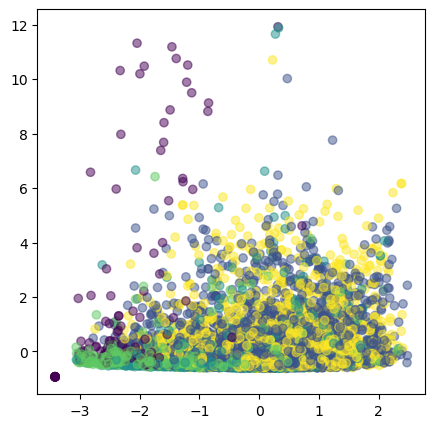

In [50]:
plt.figure(figsize=(5, 5))
plt.scatter(X_prep[:, 0], X_prep[:, 5], c=clusters,alpha=0.5)
plt.show()

# K Means

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

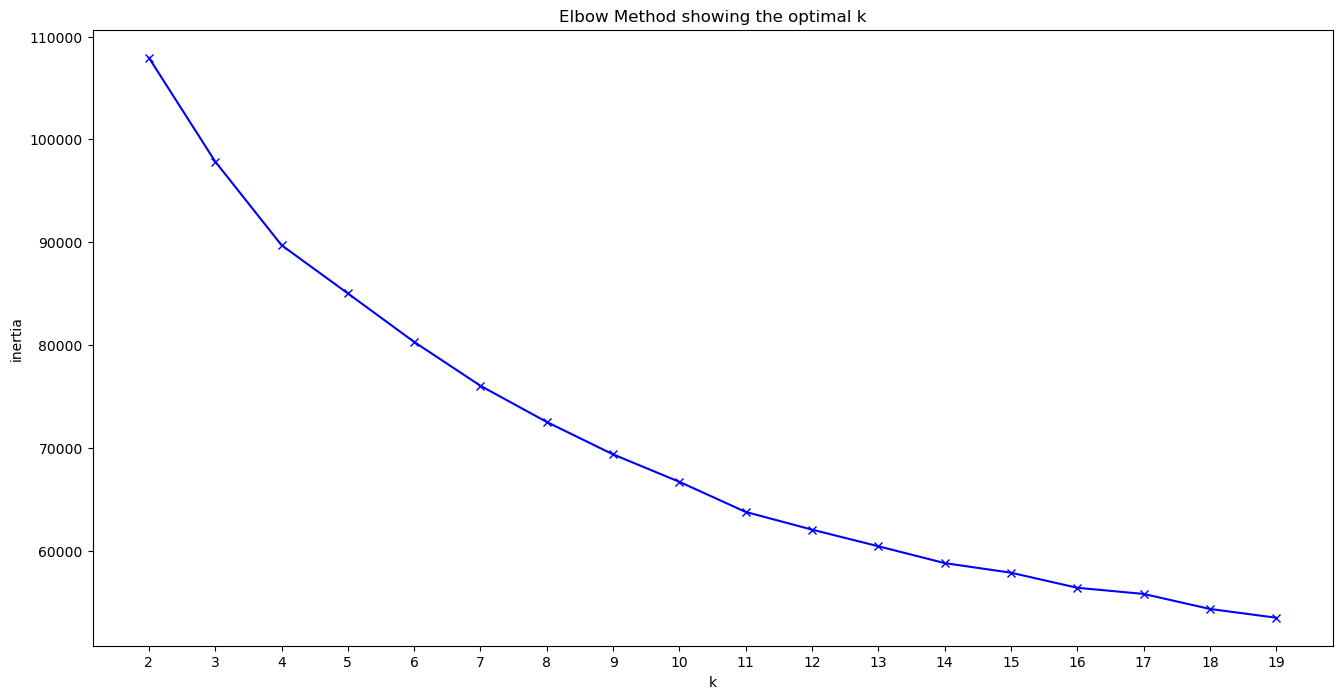

In [51]:
K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

# Silhouette score

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Text(0.5, 1.0, 'Slhouette score showing the optimal k')

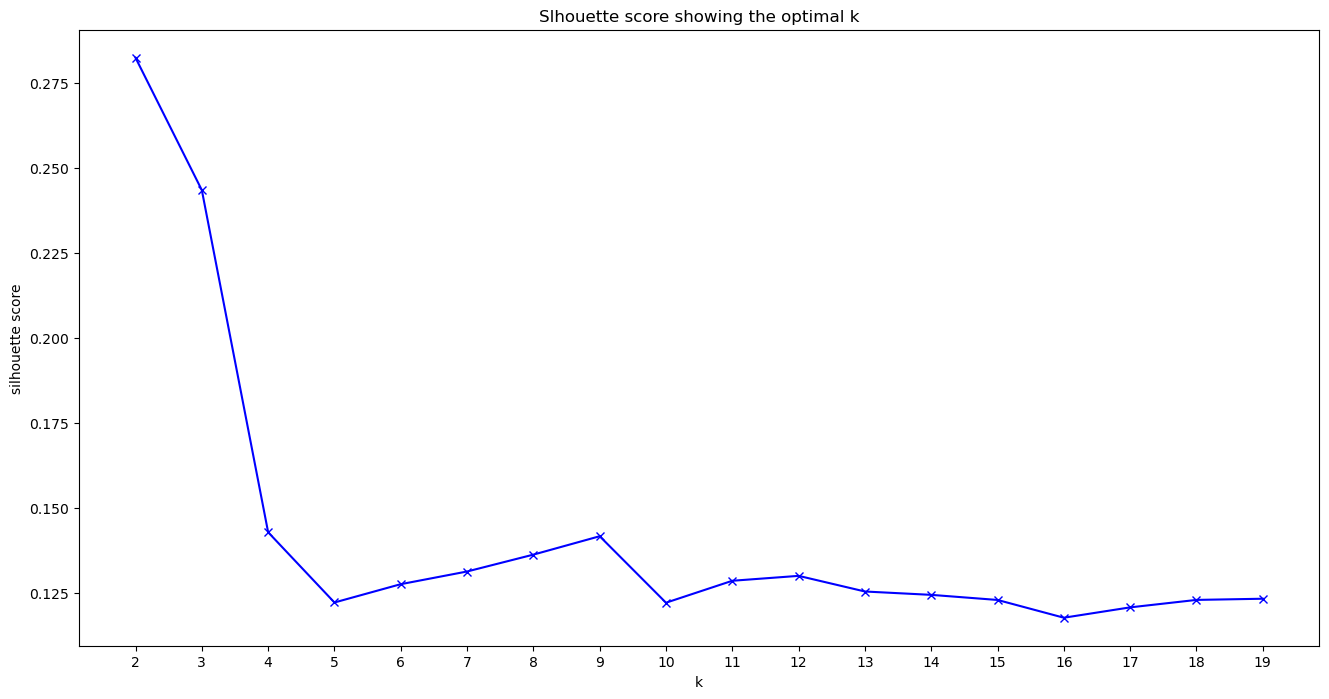

In [52]:
from sklearn.metrics import silhouette_score
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

#
The optimal number of cluster is 9

# Assigning the cluster labels

In [57]:
#My optimal number of clusters is 9
optimal_kmeans = KMeans(n_clusters=9, random_state=0)
optimal_kmeans.fit(numerical_columns)

#Assign Cluster Labels
cluster_labels = optimal_kmeans.labels_
cluster_labels

df_with_audio_features = df_with_audio_features.drop_duplicates(subset='song_id')
df_with_audio_features.shape
len(cluster_labels)

# Create clusters_df DataFrame with matching lengths
clusters_df = pd.DataFrame({'song_id': df_with_audio_features['song_id'], 'cluster': cluster_labels})
clusters_df

# Merge the cluster labels with the audio_feature data frame
audio_df = pd.merge(df_with_audio_features, clusters_df, on='song_id', how='left')


# Merge audio_feature data frame and main playlist data frame
the_final_df = pd.merge(audio_df[['song_name', 'song_id', 'cluster']], final_songs, on=['song_name','song_id'], how='inner')
the_final_df=the_final_df[['song_name','name','song_id','cluster']]
the_final_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,song_name,name,song_id,cluster
0,...Ready For It?,Taylor Swift,7zgqtptZvhf8GEmdsM2vp2,0
1,Life Changes,Thomas Rhett,4Vxu50qVrQcycjRyJQaZLC,0
2,24K Magic,Bruno Mars,6b8Be6ljOzmkOmFslEb23P,0
3,Galway Girl,Ed Sheeran,0afhq8XCExXpqazXczTSve,0
4,Photograph,Ed Sheeran,1HNkqx9Ahdgi1Ixy2xkKkL,8
...,...,...,...,...
12131,Fool's Overture,Supertramp,5pSSEkT0963muzzIjsVkrs,2
12132,Heart of the Sunrise - 2003 Remaster,Yes,7gC6Rbllqf1yXNC02e5jz2,2
12133,Venus And Mars / Rock Show / Jet - Live / Rema...,Paul McCartney,6Ff77WXC58MkhLE5A1qgY1,2
12134,Venus And Mars / Rock Show / Jet - Live / Rema...,Wings,6Ff77WXC58MkhLE5A1qgY1,2
